In [4]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64, prange
import numba
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix
from datetime import datetime
from qutip import sigmax, sigmay, sigmaz, jmat
import time
import h5py
from labellines import labelLine, labelLines
from time import sleep

In [5]:
from constants import *

In [6]:
a_par_weight = 0 # A_par/C_zz ~ 50k

file = "reconstructed_fine_full.hdf5"
couplings_file = "fine_couplings_full.hdf5"


# State reconstruction

In [7]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
            index // (max_distance**2 * site_nb) - center,
            index // (max_distance * site_nb) % max_distance - center,
            index // site_nb % max_distance - center,
            index % site_nb
        )

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return (
                            (
                                (
                                    (vec[0] + center)*max_distance + (vec[1] + center)
                                )*max_distance
                                + (vec[2] + center)
                            )*site_nb
                            + vec[3]
                       
       )


@jit
def compute_dr(i, size, distance):
    center = size // 2
    x = i // (size**2) - center
    y = (i // size) % size - center
    z = i % size - center
    return np.array([x, y, z]) * distance

@jit
def compute_all_dr(data, size, distance):
    rslt = np.empty((*data.shape,3))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            rslt[i, j] = compute_dr(data[i, j], size, distance)
    return rslt



In [8]:
 
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

###  Load data

In [9]:
from measurement_data import data_header, renormalized_data, a_par_data, nb_par_data

### Compute

In [10]:
with (
    h5py.File(file, "r") as g,
    h5py.File(couplings_file, "r") as f
):
    permutation_inv = invert_permutation(g["permutation"][:])
    config = g.attrs["config"]
    max_distance = f.attrs["max_distance"]
    base_sites = np.array([index_to_coord(c, max_distance, site_nb) for c in config])
    base_positions = lattice_x[None,:]*base_sites[:,0][:,None] + lattice_y[None,:] * base_sites[:,1][:,None] + lattice_z[None,:] * base_sites[:,2][:,None] + lattice_s[base_sites[:,3]]
    size = g.attrs["size"]
    all_displacements_index = g["sites"][:]
    all_displacements = compute_all_dr(all_displacements_index, size, g.attrs["distance"])
    all_errors = g["errors"][:]
    couplings = {
        (i, j): (np.array(f[f"/SEDOR_couplings/{i}_{j}"][:], dtype=np.float64))
            for j in range(len(a_par_data))
            for i in range(len(a_par_data))
            if f"/SEDOR_couplings/{i}_{j}" in f
    }
    a_par = np.array([f[f"A_par_couplings/{i}"][:] for i in range(len(a_par_data))])
    nb_par = np.array([f[f"Nb_par_couplings/{i}"][:] for i in range(len(a_par_data))])


In [11]:
positions = all_displacements[0][permutation_inv] + base_positions

In [12]:
all_displacements[0][permutation_inv]

array([[-5.0e-11,  5.0e-11, -2.0e-10],
       [ 5.0e-11,  2.5e-10, -2.0e-10],
       [-2.5e-10, -2.0e-10, -5.0e-11],
       [-5.0e-11,  1.5e-10, -1.0e-10],
       [-2.5e-10, -5.0e-10, -5.0e-10],
       [ 3.0e-10,  0.0e+00,  4.5e-10],
       [-2.0e-10,  1.0e-10,  4.5e-10],
       [ 2.0e-10, -1.0e-10, -2.0e-10],
       [ 5.0e-11, -1.5e-10, -5.0e-11]])

# Results overview

### Abundancy

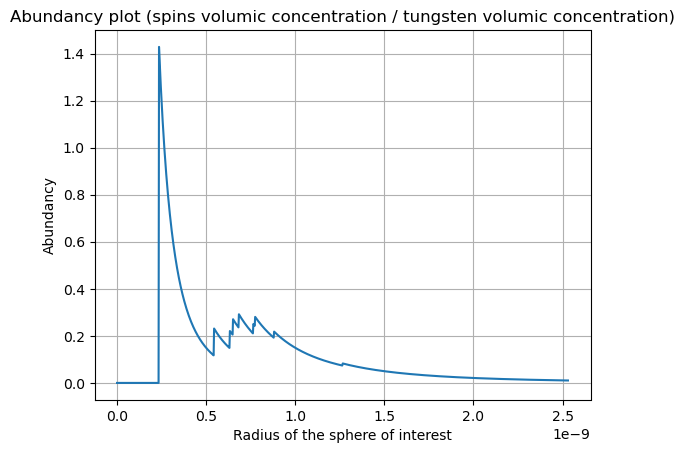

In [13]:
radius = np.max(np.linalg.norm(positions-erbium_position, axis = 1))

full_sites = np.array([index_to_coord(i, max_distance, 4) for i in range(4*max_distance**3)])
full_positions = lattice_x[None,:]*full_sites[:,0][:,None] + lattice_y[None,:] * full_sites[:,1][:,None] + lattice_z[None,:] * full_sites[:,2][:,None] + lattice_s[full_sites[:,3]]

full_concentration = 4/(a*c*a)


r = np.linspace(0.1e-30, 2*radius, 1000)

nn = np.array([np.sum(np.linalg.norm(positions-erbium_position, axis = 1) < ra) for ra in r])

fig, ax = plt.subplots(1)

ax.set_title("Abundancy plot (spins volumic concentration / tungsten volumic concentration)")

ax.set_xlabel("Radius of the sphere of interest")
ax.set_ylabel("Abundancy")
ax.grid()

ax.plot(r, nn/(4/3*np.pi*r**3)/4*a*a*c)

### Reconstruction visualisations

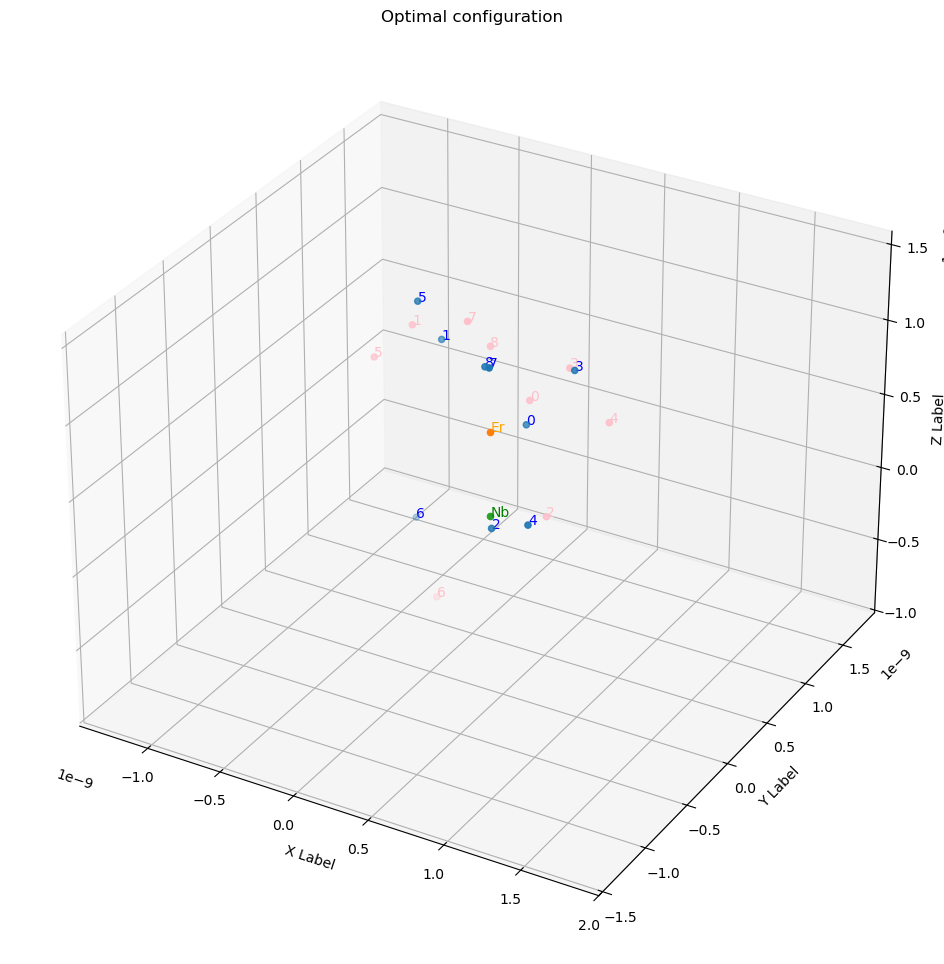

In [14]:

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.set_title(f"Optimal configuration")

ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.scatter(base_positions[:,0], base_positions[:,1], base_positions[:,2], color="pink")

ax.scatter(0.5*a, 0.5*a, 0.5*c)
ax.scatter(0.5*a, 0.5*a, 0)
ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
ax.text(0.5*a, 0.5*a, 0, "Nb", color="green")


for i in range(len(positions)):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")

for i in range(len(positions)):
    ax.text(base_positions[i,0], base_positions[i,1], base_positions[i,2], str(i), color="pink")


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')
pass


In [15]:
positions[8]

array([3.1215e-10, 1.1215e-10, 1.0876e-09])

### Comparing reconstructed data to real data

In [16]:
n = 0

config = all_displacements_index[n][permutation_inv]

reconstructed_couplings = np.array([[couplings[(i, j)][config[i],config[j]] if (i, j) in couplings else np.nan for j in range(len(config))] for i in range(len(config))])

In [17]:
def plot_comparison_table(meas, sim, cmap='summer', title='Measurement vs Simulation Comparison'):
    """
    Plots an NxN comparison table with a 2:1 figure aspect ratio.
    Cells with NaN in either measurement or simulation are left uncolored.

    Is this a better implem or the same ? => https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    """
    N = meas.shape[0]
    M = meas.shape[1]
    # Compute absolute discrepancies, ignoring NaNs for normalization
    diff = np.abs(meas - sim)
    norm = plt.Normalize(vmin=np.nanmin(diff), vmax=np.nanmax(diff))
    cmap = plt.get_cmap(cmap)
    
    # Create a wider figure: width = 2 * height
    fig, ax = plt.subplots(figsize=(2 * N*0.75+0.8, M*0.75+0.8))
    ax.set_xlim(0, N)
    ax.set_ylim(0, M)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(N+1))
    ax.set_yticks(np.arange(M+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.grid(False)
    
    for i in range(N):
        for j in range(min(i+1, M)):
            d = diff[i, j]
            # Skip coloring if NaN
            if np.isnan(d):
                cell_color = 'none'
            else:
                cell_color = cmap(norm(d))
            # Draw cell
            rect = plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black')
            ax.add_patch(rect)
            # Diagonal line
            ax.plot([i+1, i], [j, j+1], color='black', linewidth=1)
            # Text values (show 'nan' if NaN)
            meas_val = meas[i, j]
            sim_val = sim[i, j]
            txt_meas = f'{meas_val:.2f}' if not np.isnan(meas_val) else 'nan'
            txt_sim  = f'{sim_val:.2f}'  if not np.isnan(sim_val)  else 'nan'
            ax.text(i + 0.05, j + 0.15, txt_meas, va='top', ha='left', fontsize=10)
            ax.text(i + 0.95, j + 0.85, txt_sim,  va='bottom', ha='right', fontsize=10)
    
    # Colorbar (exclude NaNs)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(diff[~np.isnan(diff)])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Absolute discrepancy')
    
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


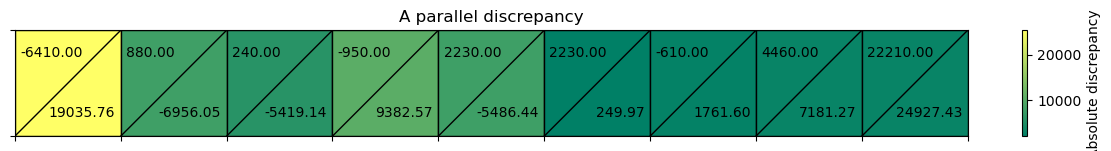

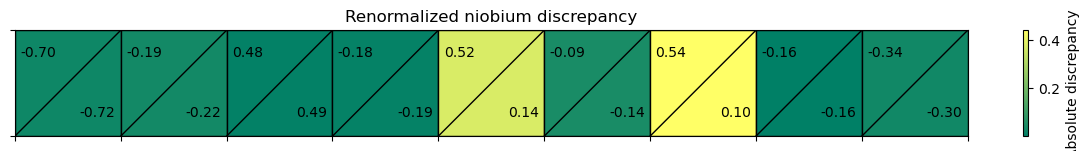

In [18]:

plot_comparison_table(a_par_data[:,None],  np.array([a_par[i, config[i]] for i in range(len(config))])[:,None], title="A parallel discrepancy")
plot_comparison_table(nb_par_data[:,None]*gamma_ratio, np.array([nb_par[i, config[i]] for i in range(len(config))])[:,None]*gamma_ratio, title="Renormalized niobium discrepancy")

In [19]:
for i in range(9):
    for j in range(9):
        if not np.isnan(reconstructed_couplings[i,j]):
            print(f"  [{i}, {j}],")

  [0, 1],
  [0, 2],
  [0, 3],
  [0, 4],
  [0, 5],
  [0, 6],
  [0, 7],
  [0, 8],
  [1, 2],
  [1, 3],
  [1, 4],
  [1, 5],
  [1, 8],
  [2, 3],
  [2, 5],
  [2, 6],
  [2, 8],
  [3, 5],
  [3, 7],
  [3, 8],


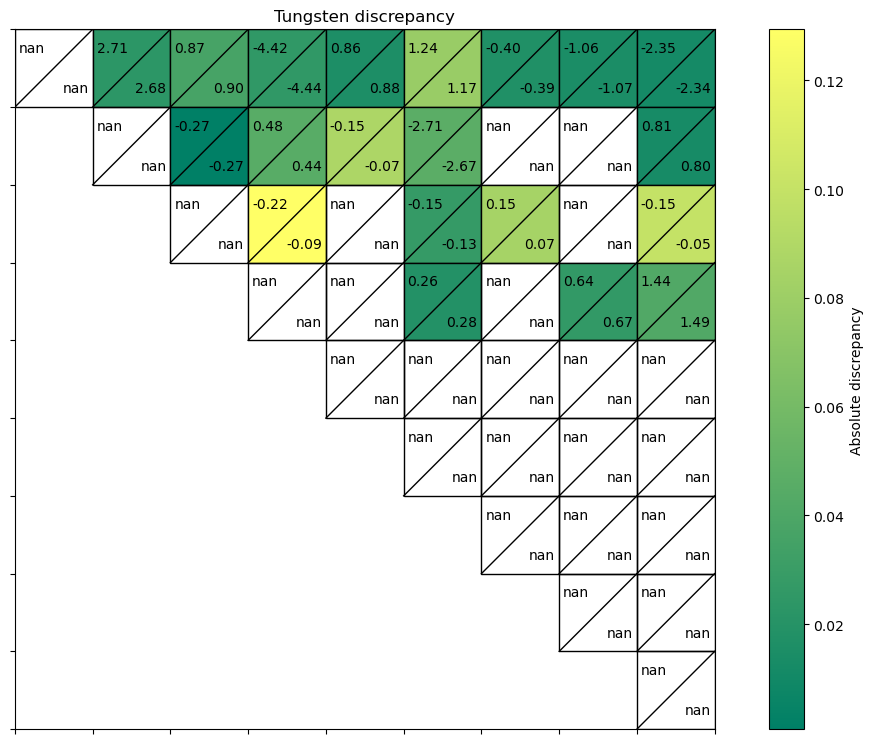

In [20]:
plot_comparison_table(renormalized_data.T, reconstructed_couplings.T, title="Tungsten discrepancy")

# Solution number estimation

In [21]:
B_key = all_keys[a_par_index][n]
print(B_key)
with (
    h5py.File(file, "r") as g
):
    a_par_key = a_par_keys[a_par_index]
        
    err = g[f"{a_par_key}/Reconstructed_from_{B_key}/errors"][:]
    all_sites = g[f"{a_par_key}/Reconstructed_from_{B_key}/sites"][:]
    permut_inv = invert_permutation(g[f"{a_par_key}/Reconstructed_from_{B_key}/permutation"][:])

NameError: name 'all_keys' is not defined

In [ ]:
fig = plt.figure(figsize=(12,5))

fig.suptitle(f"Scaling of cost value with respect to configuration number for a fixed B\nNot taking into account A parallel\nB = {B}")

ax = fig.add_subplot(1,2,1)

ax.plot(range(len(err)), err)

ax.set_xlabel("Configuration number")

ax.set_ylabel("Cost of configuration")


ax = fig.add_subplot(1,2,2, sharey=ax)

ax.set_title("Inset")

ax.plot(range(len(err)), err)
ax.set_xlim(0,100)

ax.set_xlabel("Configuration number")

ax.set_ylabel("Cost of configuration")
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,12))
for j, m in enumerate(range(0,16,4)):
    ax = fig.add_subplot(2,2,j+1, projection="3d")
    ax.set_title(f"{m}")
    sites = np.array([index_to_coord(i, max_distance, 4) for i in all_sites[m][permut_inv]], dtype = np.int64)
    positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]

    ax.scatter(positions[:,0], positions[:,1], positions[:,2])
    
    ax.scatter(0.5*a, 0.5*a, 0.5*c)
    ax.scatter(0.5*a, 0.5*a, 0)
    ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
    ax.text(0.5*a, 0.5*a, 0, "Nb", color="green")
    
    
    for i in range(len(positions)):
        ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.axis('equal')


# DEPRECATED CODE

In [ ]:
config_map = np.unique(all_final_sites, axis=0)

print(f"Number of regions = {len(config_map)}")

region = np.empty(len(all_final_sites), dtype = np.uint64)

for i, conf in enumerate(config_map):
    mask = np.all(all_final_sites == conf, axis=1)
    region[mask] = i
    

fig, ax = plt.subplots()

ax.set_title("Optimal solution")

sc = ax.scatter(all_B[:,0]*180/np.pi, all_B[:,1]*180/np.pi, c=region, cmap="hsv") #levels = np.arange(len(config_map)+1) - 0.5)

n = np.argmin(all_errors)
ax.scatter(all_B[n,0]*180/np.pi, all_B[n,1]*180/np.pi, c="red", marker="x")


n = np.argmin(np.linalg.norm(all_B[:,:2]- target_B, axis=1))
ax.scatter(all_B[n,0]*180/np.pi, all_B[n,1]*180/np.pi, c="black", marker="x")
ax.axis("equal")
cbar = fig.colorbar(sc)
cbar.set_label("Region")